# Run Sandwich Attacks on Swaps from the Public Mempool

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FixedLocator


# Set display options
pd.set_option("display.max_colwidth", None)  # Display entire cell content
pd.set_option("display.max_rows", 50)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns

from dotenv import load_dotenv
from sqlalchemy import create_engine


load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes

# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]
moralis_api_key = os.environ["MORALIS_API_KEY"]

## Get the Data

In [6]:
engine = create_engine(postgres_uri_mp)

In [7]:

sw = pd.read_sql_query(
    """
    SELECT * FROM simple_sandwiches
    """,
    engine,
)

print(f"{len(sw)} simple sandwiches")

sw.head()

106374 simple sandwiches


,user_hash,block_number,pool,token_in,token_out,profit,profit_nofee,profit_float,profit_nofee_float,gas_fee_eth,frontrun_input,price_baseline,price_frontrun,price_user,price_backrun,profit_percent,frontrun_input_float,created_at,user_input_float,profit_per_user_input,profit_usd
0,0xc2c20f333dc00428af357e2b94132edb07a856ead9e733834b269841172846ad,17543475,0xda09c49e24ac571058fea2e25f5825910960f266,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6034e0d6999741f07cb6fb1162cbaa46a1d33d36,9939570862307328.0,9939570862307328.0,9.939571e+15,9.939571e+15,0.008527,625260009765625100,0.029893,0.030194,0.030434,0.030129,0.015897,6.252600e+17,2023-08-21 20:15:15.963778+00:00,5.000000e+17,0.019879,18.966131
1,0x05d88cc399fbdf412d66e35fce4bc9d1755be1fc440d805a77864c16a01a8838,17753030,0x25392d7129040710f152174af5019004a6f9b18d,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,1778929879162456.0,1941613944222956.0,1.778930e+15,1.941614e+15,0.003519,25950565338134760,504.388435,535.332921,555.601712,522.437820,0.068551,2.595057e+16,2023-08-17 17:44:43.031393+00:00,1.700000e+16,0.104643,3.331459
2,0x10efb78bd42f69d7954fbbeec3acf959b8f7f4153a0276dafdd11b0ad4701507,17764448,0x25392d7129040710f152174af5019004a6f9b18d,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,0.0,0.0,0.000000e+00,0.000000e+00,0.011252,0.0,517.963473,517.963473,529.883886,529.883886,0.000000,0.000000e+00,2023-08-17 17:44:52.795973+00:00,1.000000e+16,0.000000,0.000000
3,0x49203f7ac3dafa54756f8fc2865e8a7e4fe2c3c45556e341a42e0d4cc4500891,17776161,0x25392d7129040710f152174af5019004a6f9b18d,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.0,0.0,0.000000e+00,0.000000e+00,0.004118,0.0,487.441719,487.441719,477.649065,477.649065,0.000000,0.000000e+00,2023-08-17 17:45:02.491491+00:00,3.527956e+10,0.000000,0.000000
4,0x05d53b345edade3a4a199480188d6f0bdc5b5bb2d5e8e7b8d6ac3e6dd9f09e6d,17777471,0x25392d7129040710f152174af5019004a6f9b18d,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.0,0.0,0.000000e+00,0.000000e+00,0.007774,0.0,620.815603,620.815603,573.170499,573.170499,0.000000,0.000000e+00,2023-08-17 17:45:12.194309+00:00,1.122925e+11,0.000000,0.000000


## Inspect the sandwiches created

Removed 186 outliers (0.17%))


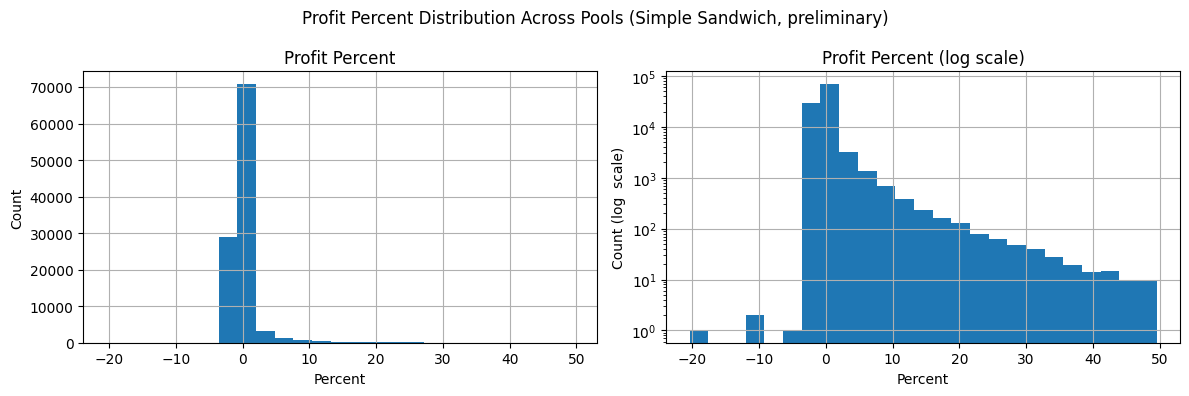

In [8]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

profits = sw.profit_percent
cnt_before = len(profits)
profits = profits[(profits < .5) & (profits > -.5)]
cnt_after = len(profits)

print(f"Removed {cnt_before - cnt_after} outliers ({(cnt_before - cnt_after) / cnt_before * 100:.2f}%))")

(profits * 100).hist(bins=25, ax=ax1)
(profits * 100).hist(bins=25, ax=ax2)

# Make log y axis
ax2.set_yscale('log')

# Set titles
ax1.set_title('Profit Percent')
ax2.set_title('Profit Percent (log scale)')

# Set x labels
ax1.set_xlabel('Percent')
ax2.set_xlabel('Percent')

# Set y labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count (log  scale)');

# Subtitle
plt.suptitle('Profit Percent Distribution Across Pools (Simple Sandwich, preliminary)');

plt.tight_layout()

In [9]:
sw = sw.assign(profit_profitable=sw.profit_percent.apply(lambda x: x if x > 0 else 0))
f"{sw.profit_profitable.mean():.2%}"

'1.97%'

### Look at profitability relative to user swap size

In [10]:
sw.columns

Index(['user_hash', 'block_number', 'pool', 'token_in', 'token_out', 'profit',
       'profit_nofee', 'profit_float', 'profit_nofee_float', 'gas_fee_eth',
       'frontrun_input', 'price_baseline', 'price_frontrun', 'price_user',
       'price_backrun', 'profit_percent', 'frontrun_input_float', 'created_at',
       'user_input_float', 'profit_per_user_input', 'profit_usd',
       'profit_profitable'],
      dtype='object')

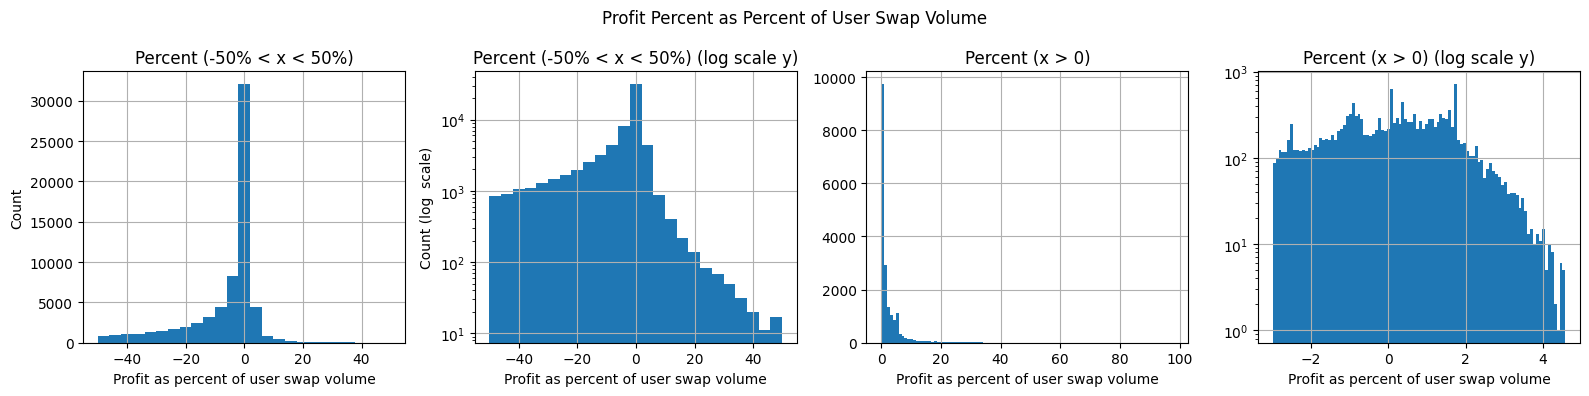

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))

prof_per_input = sw.profit_per_user_input
prof_per_input = prof_per_input[(prof_per_input < .5) & (prof_per_input > -.5)]

(prof_per_input * 100).hist(bins=25, ax=ax1)
(prof_per_input * 100).hist(bins=25, ax=ax2)

# Add 3rd plot that only shows strictly positive values
prof_per_input = sw.profit_per_user_input
(prof_per_input[prof_per_input > 0] * 100).hist(bins=100, ax=ax3)
np.log((prof_per_input[prof_per_input.round(3) > 0] * 100)).hist(bins=100, ax=ax4)

# Make log y axis
ax2.set_yscale('log')
ax4.set_yscale('log')
# ax4.set_xscale('log')

# Set titles
ax1.set_title('Percent (-50% < x < 50%)')
ax2.set_title('Percent (-50% < x < 50%) (log scale y)')
ax3.set_title('Percent (x > 0)')
ax4.set_title('Percent (x > 0) (log scale y)')

# Set x labels
xlab = 'Profit as percent of user swap volume'
ax1.set_xlabel(xlab)
ax2.set_xlabel(xlab)
ax3.set_xlabel(xlab)
ax4.set_xlabel(xlab)

# Set y labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count (log  scale)');

# Subtitle
fig.suptitle('Profit Percent as Percent of User Swap Volume');

plt.tight_layout()

In [12]:
def get_profit_per_user_input(df):
    only_profitable_per_user_input = df.profit_per_user_input.apply(lambda x: x if x > 0 else 0)
    mean_over_percent = f"{only_profitable_per_user_input.mean():.4%}"
    print(mean_over_percent)

    # percent_over_mean = f"{df.profit_float.apply(lambda x: x if x > 0 else 0).sum() / df.user_input_float.sum():.2%}"
    # print(percent_over_mean)


get_profit_per_user_input(sw)

0.5065%


In [13]:
# How many swaps earn more than 10%, 50%, and 90% of the volume of the user swap?
print(f"Number x > 10%: {sw[sw.profit_per_user_input > 0.1].shape[0] / sw.shape[0]:.2%}")
print(f"Number x > 50%: {sw[sw.profit_per_user_input > 0.5].shape[0] / sw.shape[0]:.2%}")
print(f"Number x > 90%: {sw[sw.profit_per_user_input > 0.9].shape[0] / sw.shape[0]:.2%}")

Number x > 10%: 1.02%
Number x > 50%: 0.06%
Number x > 90%: 0.00%


In [14]:
sw_ordered = sw.sort_values("profit_per_user_input", ascending=True)

print("99%")
get_profit_per_user_input(sw_ordered.iloc[:int(len(sw_ordered) * 0.99)])
print("95%")
get_profit_per_user_input(sw_ordered.iloc[:int(len(sw_ordered) * 0.95)])
print("90%")
get_profit_per_user_input(sw_ordered.iloc[:int(len(sw_ordered) * 0.90)])

99%
0.2919%
95%
0.0913%
90%
0.0177%


Text(0, 0.5, 'Profit per user input')

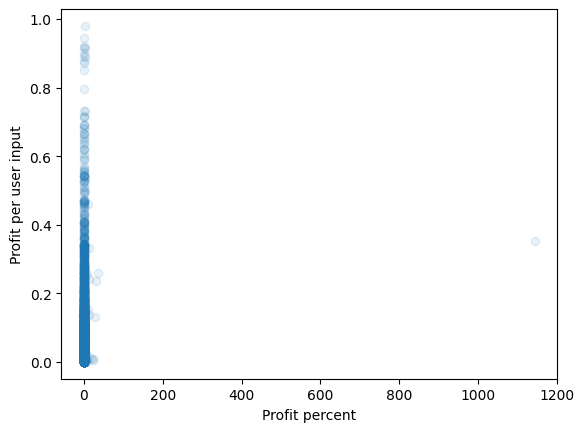

In [15]:
sw_profitable = sw[sw['profit_float'] > 0]

plt.scatter(sw_profitable['profit_percent'], sw_profitable['profit_per_user_input'], alpha=0.1);
plt.xlabel('Profit percent')
plt.ylabel('Profit per user input')

### Look at what pools have the most profitable swaps

In [16]:
engine_us = create_engine(postgres_uri_us)

pool_info = pd.read_sql_query("SELECT * FROM token_info", engine_us).set_index('pool')

pool_info.head()

,block_timestamp,block_number,transaction_hash,log_index,token0,token1,fee,tick_spacing,token0symbol,decimals0,token1symbol,decimals1
pool,,,,,,,,,,,,
0x3ffedcddd268511acc44ae67845bdd56c8417fa4,2022-05-07 04:04:57+00:00,14727619,0x608b28353bd9e08824c450b60aeec0e24fdf8921049aa0acbc79c2276d0689f9,222,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,100,1,WBTC,8.0,FUN,8.0
0xf8bc8c39a82506dc0709e626b2e882a014bb9838,2023-04-12 09:52:35+00:00,17031160,0x8c84ecaabba61d00af64fe4f272404d52cb06f60656ce0c1d467934f8fbed168,236,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x66a0f676479cee1d7373f3dc2e2952778bff5bd6,100,1,HEX,8.0,WISE,18.0
0xe82c5c1ec82124ddf833800a3b61a3ec7106b18b,2021-11-13 07:18:03+00:00,13606313,0x505efb367d2a29b2ddc89f38f36a20216238cd30673bab9847f3333e22a4945a,307,0x056fd409e1d7a124bd7017459dfea2f387b6d5cd,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,GUSD,2.0,DAI,18.0
0x75bff91af9878f5ec3fede9b52d51159afc2430a,2022-05-07 04:20:49+00:00,14727691,0x2e3cc9a2dfa8d48930054952a844bef7303304250b738a445b9e1d1483c70f0b,371,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,FUN,8.0,DAI,18.0
0xd1000344c3a00846462b4624bb452621cf2ce001,2021-11-13 07:18:03+00:00,13606313,0xf9d2dab791e3a006f2ffdade52cbf6c4a8c49a9c8cba5dbe4793014d5e2b2d76,301,0x4fabb145d64652a948d72533023f6e7a623c7c53,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,BUSD,18.0,DAI,18.0


In [17]:
pool_info = pool_info.assign(pool_name=pool_info.apply(lambda x: f"{x['token0symbol']}-{x['token1symbol']}", axis=1))

pool_info = pool_info[['pool_name']]

In [18]:
sw = pd.merge(sw, pool_info, on='pool', how='left')

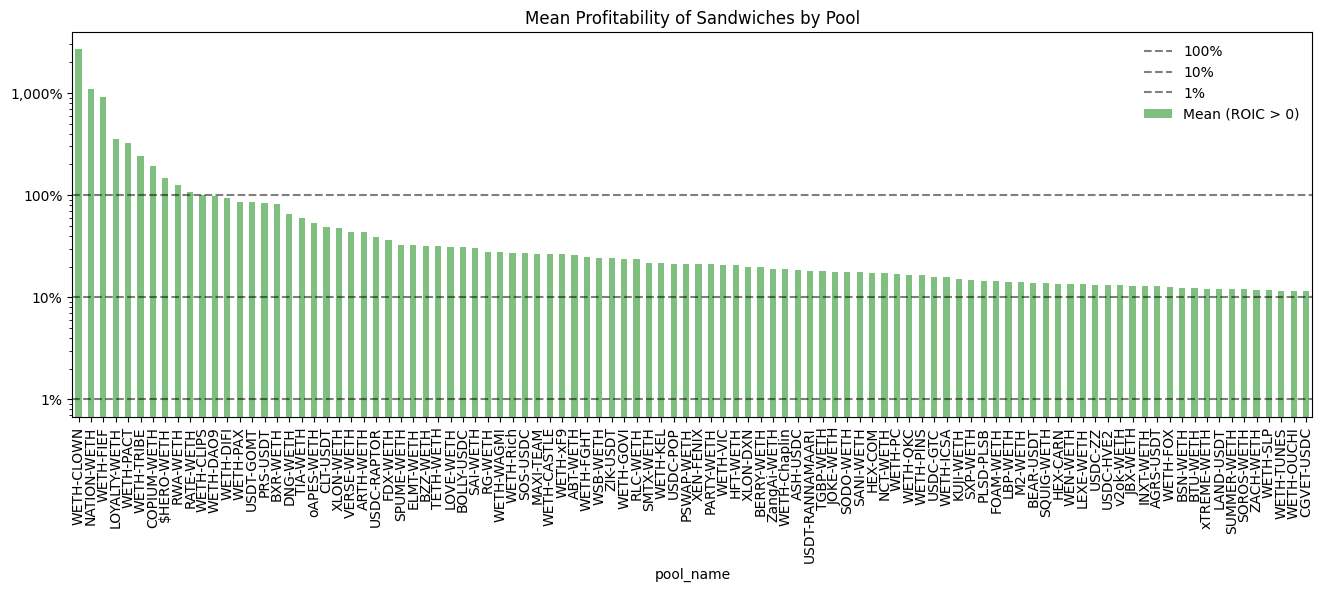

In [21]:
_, ax = plt.subplots(figsize=(16, 5))
mean_per_pool = sw.groupby('pool_name').profit_profitable.mean()
(mean_per_pool[mean_per_pool > 0]).sort_values(ascending=False)[:100].plot.bar(ax=ax, color='green', alpha=0.5, label='Mean (ROIC > 0)')

ax.axhline(1, color='black', linestyle='--', alpha=0.5, label='100%')
ax.axhline(0.1, color='black', linestyle='--', alpha=0.5, label='10%')
ax.axhline(0.01, color='black', linestyle='--', alpha=0.5, label='1%')

ax.set_title('Mean Profitability of Sandwiches by Pool')

ax.set_yscale('log')

# Format the y-axis as a percentage
vals = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(vals))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.legend(frameon=False);

Text(0.5, 0, 'USD')

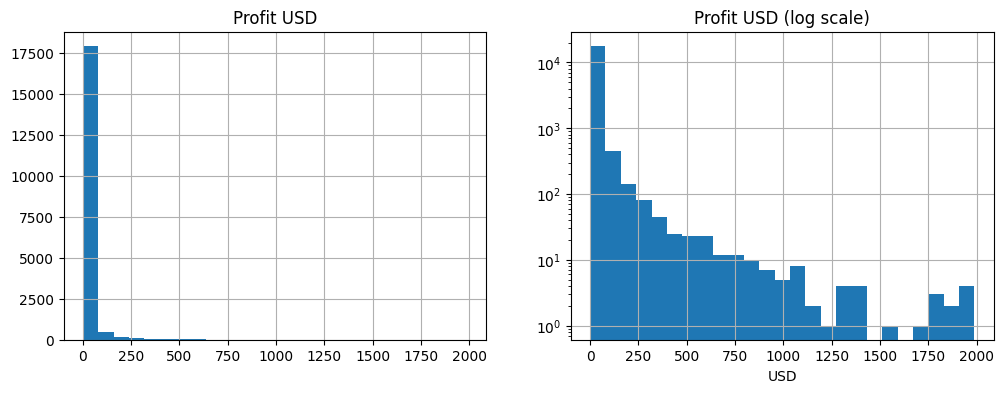

In [28]:
profit_usd = sw[(~sw.profit_usd.isna()) & (sw.profit_usd > 0) & (sw.profit_usd < 2e3)].profit_usd

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

(profit_usd).hist(bins=25, ax=ax1)
(profit_usd).hist(bins=25, ax=ax2)

# Make log y axis
ax2.set_yscale('log')

# Set titles
ax1.set_title('Profit USD')
ax2.set_title('Profit USD (log scale)')
ax2.set_xlabel('USD')


## Spurious calculations

In [ ]:
# ## Get the Data
engine_mp = create_engine(postgres_uri_mp)
engine_us = create_engine(postgres_uri_us)

query = """
    SELECT *
    FROM SWAP_LIMIT_PRICE AS LIM
    INNER JOIN MEMPOOL_TRANSACTIONS AS MEM ON LIM.transaction_hash = MEM.HASH
    WHERE LIM.transaction_type = 'V3_SWAP_EXACT_IN'
"""


df = pd.read_sql_query(query, engine_mp)

block_numbers = pd.read_sql_query(
    """
    SELECT block_number, tx_hash, block_ts
    FROM swaps
    WHERE block_number >= 17400000
    ORDER BY block_ts ASC
    """,
    engine_us,
).set_index("tx_hash")

block_number_dict = block_numbers[
    ~block_numbers.index.duplicated(keep="first")
].to_dict(orient="index")

dataset = df.assign(
    block_number=df.transaction_hash.map(
        lambda x: block_number_dict[x]["block_number"]
        if x in block_number_dict
        else None
    )
)
dataset = dataset[~dataset.block_number.isna()]

swap_counts = (
    dataset.groupby(by=["pool", "block_number"])[["transaction_hash"]]
    .count()
    .sort_values("transaction_hash", ascending=False)
)

In [ ]:
f"{swap_counts[swap_counts.transaction_hash == 3].shape[0] / swap_counts.shape[0]:.1%}"


'0.5%'

In [ ]:
# Given 17 seconds per sandwich, how many sandwiches can you make in a night?
hours_per_night = 8
seconds_per_sandwich = 17
cpus = 1

hours_per_night * 60 * 60 / seconds_per_sandwich * cpus

1694.1176470588234

## Get a pool and do some initial testing

In [ ]:
swap_data = df[df.hash == '0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2']

swap = SwapData(**swap_data.reset_index().to_dict('records')[0]) # type: ignore

swap

SwapData(pool='0x78d4e81fc84a1ce367e90936e49a74a9052137e8', block_number=17578916.0, amountIn='10000000000000000000', amountOutMin='466622823911182083', token0='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', fee='10000', token1='0x2890df158d76e584877a1d17a85fea3aeeb85aa6', hash='0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2', first_seen=Timestamp('2023-06-28 16:09:49.897000+0000', tz='UTC'))

In [ ]:
pool = load_pool_from_blob(
    str(swap_data.index.get_level_values(0)[0]),
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 16, tzinfo=timezone.utc),
)

Loading pool from Azure blob storage cache


In [ ]:
assert pool

max_frontrun(
    pool,
    swap,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 2000000.0
2: Trying 4000000.0
3: Trying 8000000.0
4: Trying 16000000.0
5: Trying 32000000.0
6: Trying 64000000.0
7: Trying 128000000.0
8: Trying 256000000.0
9: Trying 512000000.0
10: Trying 1024000000.0
11: Trying 2048000000.0
12: Trying 4096000000.0
13: Trying 8192000000.0
14: Trying 16384000000.0
15: Trying 32768000000.0
16: Trying 65536000000.0
17: Trying 131072000000.0
18: Trying 262144000000.0
19: Trying 524288000000.0
20: Trying 1048576000000.0
21: Trying 2097152000000.0
22: Trying 4194304000000.0
23: Trying 8388608000000.0
24: Trying 16777216000000.0
25: Trying 33554432000000.0
26: Trying 67108864000000.0
27: Trying 134217728000000.0
28: Trying 268435456000000.0
29: Trying 536870912000000.0
30: Trying 1073741824000000.0
31: Trying 2147483648000000.0
32: Trying 4294967296000000.0
33: Trying 8589934592000000.0
34: Trying 1.7179869184e+16
35: Trying 3.4359738368e+16
36: Trying 6.8719476736e+16
37: Trying 1.37438953472e+17
38: Trying 2.74877906944e+17
0

2.72994664448e+17

In [ ]:
assert pool is not None

profit, gas, prices = single_sandwich_mev(
    pool,
    swap,
    int(2.72994664448e+17),
    pool_fee=True,
)

print(f"Profit: {profit / 1e18}")
print(f"Gas: {gas}")
print(f"Prices: {prices}")

Profit: 0.003185129981081248
Gas: 0.006719305386569982
Prices: (4.56768883595478, 4.569668914667892, 4.642682234572798, 4.64065881939532)


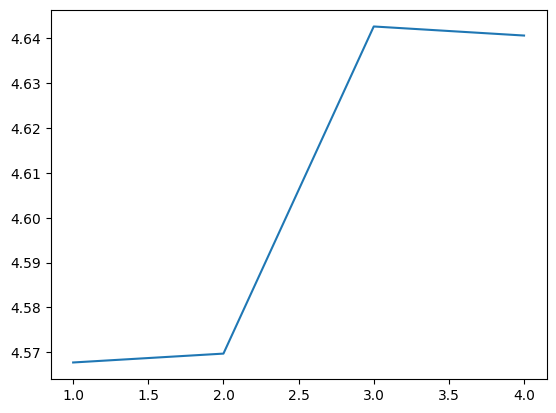

In [ ]:
plt.plot([1,2,3,4], prices);

In [ ]:
# See if the profit of the profitable attack is maximized by inserting the maximum size frontrunning swap

xs = []
ys = []

inp = 1e12

while inp <= int(2.72994664448e+19):
    print(f"Running {inp:.2e} <= 2.73e+19")
    profit, gas, prices = single_sandwich_mev(
        pool,
        swap,
        int(inp),
        pool_fee=True,
    )

    xs.append(inp)
    ys.append(profit)

    inp *= 2

Running 1.00e+12 <= 2.73e+19
Running 2.00e+12 <= 2.73e+19
Running 4.00e+12 <= 2.73e+19
Running 8.00e+12 <= 2.73e+19
Running 1.60e+13 <= 2.73e+19
Running 3.20e+13 <= 2.73e+19
Running 6.40e+13 <= 2.73e+19
Running 1.28e+14 <= 2.73e+19
Running 2.56e+14 <= 2.73e+19
Running 5.12e+14 <= 2.73e+19
Running 1.02e+15 <= 2.73e+19
Running 2.05e+15 <= 2.73e+19
Running 4.10e+15 <= 2.73e+19
Running 8.19e+15 <= 2.73e+19
Running 1.64e+16 <= 2.73e+19
Running 3.28e+16 <= 2.73e+19
Running 6.55e+16 <= 2.73e+19
Running 1.31e+17 <= 2.73e+19
Running 2.62e+17 <= 2.73e+19
Running 5.24e+17 <= 2.73e+19
Running 1.05e+18 <= 2.73e+19
Running 2.10e+18 <= 2.73e+19
Running 4.19e+18 <= 2.73e+19
Running 8.39e+18 <= 2.73e+19
Running 1.68e+19 <= 2.73e+19


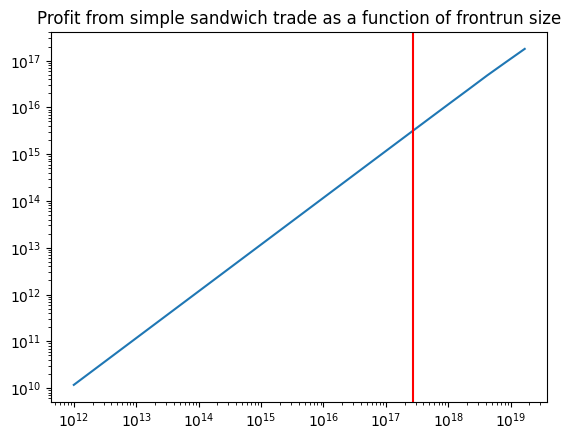

In [ ]:
plt.plot(xs, ys)
plt.loglog()
plt.axvline(x=2.72994664448e+17, color='red')
plt.title('Profit from simple sandwich trade as a function of frontrun size');

In [ ]:
assert pool is not None

auto_sandwich_mev(
    pool,
    swap,
    start=1e12,
    factor=10,
    pool_fee=True,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 10000000.0
2: Trying 100000000.0
3: Trying 1000000000.0
4: Trying 10000000000.0
5: Trying 100000000000.0
6: Trying 1000000000000.0
7: Trying 10000000000000.0
0: Trying 1000000000000.0 - 10000000000000.0
1: Trying 5500000000000.0 - 10000000000000.0
2: Trying 5500000000000.0 - 7750000000000.0
3: Trying 5500000000000.0 - 6625000000000.0
4: Trying 6062500000000.0 - 6625000000000.0
5: Trying 6343750000000.0 - 6625000000000.0
6: Trying 6343750000000.0 - 6484375000000.0
7: Trying 6343750000000.0 - 6414062500000.0
8: Trying 6343750000000.0 - 6378906250000.0
9: Trying 6343750000000.0 - 6361328125000.0
10: Trying 6352539062500.0 - 6361328125000.0
11: Trying 6352539062500.0 - 6356933593750.0
12: Trying 6352539062500.0 - 6354736328125.0
13: Trying 6352539062500.0 - 6353637695312.0
14: Trying 6352539062500.0 - 6353088378906.0
15: Trying 6352813720703.0 - 6353088378906.0
16: Trying 6352951049804.0 - 6353088378906.0
17: Trying 6353019714355.0 - 6353088378906.0
18: Trying

AutoSandwichResult(profit=-6284193032.0, gas_fee=0.007010483569918752, frontrun_input=6353019714355.0, price_baseline=4.3577930944809406e-05, price_frontrun=4.4178991727856794e-05, price_user=4.417908996981208e-05, price_backrun=4.35782501103994e-05)